#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Exploring the TF-Hub CORD-19 Swivel Embeddings


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cord_19_embeddings_keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/tensorflow/cord-19/swivel-128d/3"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

The CORD-19 Swivel text embedding module from TF-Hub (https://tfhub.dev/tensorflow/cord-19/swivel-128d/3)
 was built to support researchers analyzing natural languages text related to COVID-19.
These embeddings were trained on the titles, authors, abstracts, body texts, and
reference titles of articles in the [CORD-19 dataset](https://api.semanticscholar.org/CorpusID:216056360).

In this colab we will:
- Analyze semantically similar words in the embedding space
- Train a classifier on the SciCite dataset using the CORD-19 embeddings


## Setup


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tqdm import trange

2023-10-09 22:29:39.063949: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 22:29:39.064004: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 22:29:39.064046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Analyze the embeddings

Let's start off by analyzing the embedding by calculating and plotting a correlation matrix between different terms. If the embedding learned to successfully capture the meaning of different words, the embedding vectors of semantically similar words should be close together. Let's take a look at some COVID-19 related terms.

2023-10-09 22:29:44.568345: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


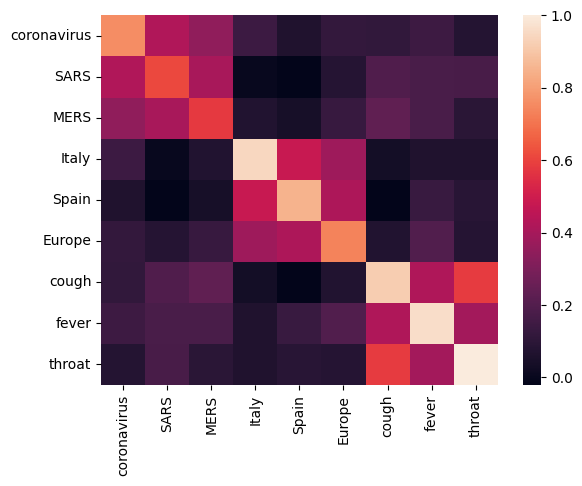

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)

# Generate embeddings for some terms
queries = [
  # Related viruses
  'coronavirus', 'SARS', 'MERS',
  # Regions
  'Italy', 'Spain', 'Europe',
  # Symptoms
  'cough', 'fever', 'throat'
]

module = hub.load('https://tfhub.dev/tensorflow/cord-19/swivel-128d/3')
embeddings = module(queries)

plot_correlation(queries, embeddings)

We can see that the embedding successfully captured the meaning of the different terms. Each word is similar to the other words of its cluster (i.e. "coronavirus" highly correlates with "SARS" and "MERS"), while they are different from terms of other clusters (i.e. the similarity between "SARS" and "Spain" is close to 0).

Now let's see how we can use these embeddings to solve a specific task.

## SciCite: Citation Intent Classification

This section shows how one can use the embedding for downstream tasks such as text classification. We'll use the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) from TensorFlow Datasets to classify citation intents in academic papers. Given a sentence with a citation from an academic paper, classify whether the main intent of the citation is as background information, use of methods, or comparing results.

In [4]:
builder = tfds.builder(name='scicite')
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split=('train', 'validation', 'test'),
    as_supervised=True)

In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES =   10#@param {type:"integer"}

TEXT_FEATURE_NAME = builder.info.supervised_keys[0]
LABEL_NAME = builder.info.supervised_keys[1]

def label2str(numeric_label):
  m = builder.info.features[LABEL_NAME].names
  return m[numeric_label]

data = next(iter(train_data.batch(NUM_EXAMPLES)))


pd.DataFrame({
    TEXT_FEATURE_NAME: [ex.numpy().decode('utf8') for ex in data[0]],
    LABEL_NAME: [label2str(x) for x in data[1]]
})

string       label
0  The finding that BMI is closely related to TBF...      result
1  The average magnitude of the NBR increases wit...  background
2  It has been reported that NF-κB activation can...      result
3  , 2008; Quraan and Cheyne, 2008; Quraan and Ch...  background
4  5B), but, interestingly, they shared conserved...  background
5  Some investigators have noted an association o...  background
6  In our previous study, it is documented that b...  background
7  These subjects have intact cognitive function ...  background
8  Another study reported improved knee function ...  background
9  C. Data Analysis Transcription Speech samples ...      method

## Training a citaton intent classifier

We'll train a classifier on the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) using Keras.  Let's build a model which use the CORD-19 embeddings with a classification layer on top.

In [6]:
#@title Hyperparameters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/3'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}

hub_layer = hub.KerasLayer(EMBEDDING, input_shape=[], 
                           dtype=tf.string, trainable=TRAINABLE_MODULE)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(3))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 128)               17301632  


 dense (Dense)               (None, 3)                 387       


Total params: 17302019 (132.00 MB)


Trainable params: 387 (1.51 KB)


Non-trainable params: 17301632 (132.00 MB)


_________________________________________________________________


## Train and evaluate the model

Let's train and evaluate the model to see the performance on the SciCite task

In [7]:
EPOCHS = 35#@param {type: "integer"}
BATCH_SIZE = 32#@param {type: "integer"}

history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=validation_data.batch(BATCH_SIZE),
                    verbose=1)

Epoch 1/35


  1/257 [..............................] - ETA: 3:35 - loss: 0.9007 - accuracy: 0.5938

 27/257 [==>...........................] - ETA: 0s - loss: 1.0218 - accuracy: 0.5058  

 55/257 [=====>........................] - ETA: 0s - loss: 0.9746 - accuracy: 0.5466

 83/257 [========>.....................] - ETA: 0s - loss: 0.9468 - accuracy: 0.5693

111/257 [===========>..................] - ETA: 0s - loss: 0.9221 - accuracy: 0.5873

139/257 [===============>..............] - ETA: 0s - loss: 0.8993 - accuracy: 0.6003

167/257 [==================>...........] - ETA: 0s - loss: 0.8773 - accuracy: 0.6158

196/257 [=====================>........] - ETA: 0s - loss: 0.8647 - accuracy: 0.6269

225/257 [=========================>....] - ETA: 0s - loss: 0.8496 - accuracy: 0.6372

254/257 [============================>.] - ETA: 0s - loss: 0.8406 - accuracy: 0.6409

257/257 [==============================] - 2s 4ms/step - loss: 0.8391 - accuracy: 0.6421 - val_loss: 0.7495 - val_accuracy: 0.7020


Epoch 2/35


  1/257 [..............................] - ETA: 1:18 - loss: 0.7209 - accuracy: 0.7500

 28/257 [==>...........................] - ETA: 0s - loss: 0.7295 - accuracy: 0.6975  

 56/257 [=====>........................] - ETA: 0s - loss: 0.7255 - accuracy: 0.7093

 84/257 [========>.....................] - ETA: 0s - loss: 0.7026 - accuracy: 0.7169

112/257 [============>.................] - ETA: 0s - loss: 0.6977 - accuracy: 0.7224

140/257 [===============>..............] - ETA: 0s - loss: 0.6866 - accuracy: 0.7275

168/257 [==================>...........] - ETA: 0s - loss: 0.6833 - accuracy: 0.7279

196/257 [=====================>........] - ETA: 0s - loss: 0.6820 - accuracy: 0.7269

224/257 [=========================>....] - ETA: 0s - loss: 0.6796 - accuracy: 0.7268

252/257 [============================>.] - ETA: 0s - loss: 0.6784 - accuracy: 0.7282

257/257 [==============================] - 1s 3ms/step - loss: 0.6784 - accuracy: 0.7282 - val_loss: 0.6634 - val_accuracy: 0.7380


Epoch 3/35


  1/257 [..............................] - ETA: 1:22 - loss: 0.6186 - accuracy: 0.7500

 28/257 [==>...........................] - ETA: 0s - loss: 0.6165 - accuracy: 0.7690  

 56/257 [=====>........................] - ETA: 0s - loss: 0.6169 - accuracy: 0.7584

 84/257 [========>.....................] - ETA: 0s - loss: 0.6221 - accuracy: 0.7571

112/257 [============>.................] - ETA: 0s - loss: 0.6297 - accuracy: 0.7525

141/257 [===============>..............] - ETA: 0s - loss: 0.6277 - accuracy: 0.7524

169/257 [==================>...........] - ETA: 0s - loss: 0.6260 - accuracy: 0.7504

198/257 [======================>.......] - ETA: 0s - loss: 0.6270 - accuracy: 0.7509

227/257 [=========================>....] - ETA: 0s - loss: 0.6222 - accuracy: 0.7536

256/257 [============================>.] - ETA: 0s - loss: 0.6175 - accuracy: 0.7561

257/257 [==============================] - 1s 3ms/step - loss: 0.6175 - accuracy: 0.7562 - val_loss: 0.6269 - val_accuracy: 0.7478


Epoch 4/35


  1/257 [..............................] - ETA: 1:23 - loss: 0.6516 - accuracy: 0.7188

 28/257 [==>...........................] - ETA: 0s - loss: 0.5755 - accuracy: 0.7958  

 56/257 [=====>........................] - ETA: 0s - loss: 0.5936 - accuracy: 0.7846

 84/257 [========>.....................] - ETA: 0s - loss: 0.5952 - accuracy: 0.7783

112/257 [============>.................] - ETA: 0s - loss: 0.5916 - accuracy: 0.7796

140/257 [===============>..............] - ETA: 0s - loss: 0.5907 - accuracy: 0.7746

169/257 [==================>...........] - ETA: 0s - loss: 0.5856 - accuracy: 0.7740

198/257 [======================>.......] - ETA: 0s - loss: 0.5880 - accuracy: 0.7711

227/257 [=========================>....] - ETA: 0s - loss: 0.5836 - accuracy: 0.7720

255/257 [============================>.] - ETA: 0s - loss: 0.5860 - accuracy: 0.7700

257/257 [==============================] - 1s 3ms/step - loss: 0.5858 - accuracy: 0.7706 - val_loss: 0.6035 - val_accuracy: 0.7533


Epoch 5/35


  1/257 [..............................] - ETA: 1:35 - loss: 0.5927 - accuracy: 0.7188

 29/257 [==>...........................] - ETA: 0s - loss: 0.5530 - accuracy: 0.7716  

 58/257 [=====>........................] - ETA: 0s - loss: 0.5693 - accuracy: 0.7737

 87/257 [=========>....................] - ETA: 0s - loss: 0.5675 - accuracy: 0.7802

116/257 [============>.................] - ETA: 0s - loss: 0.5675 - accuracy: 0.7786

145/257 [===============>..............] - ETA: 0s - loss: 0.5653 - accuracy: 0.7793

174/257 [===================>..........] - ETA: 0s - loss: 0.5694 - accuracy: 0.7764

204/257 [======================>.......] - ETA: 0s - loss: 0.5677 - accuracy: 0.7782

233/257 [==========================>...] - ETA: 0s - loss: 0.5670 - accuracy: 0.7790

257/257 [==============================] - 1s 3ms/step - loss: 0.5674 - accuracy: 0.7780 - val_loss: 0.5914 - val_accuracy: 0.7576


Epoch 6/35


  1/257 [..............................] - ETA: 1:23 - loss: 0.4241 - accuracy: 0.8125

 28/257 [==>...........................] - ETA: 0s - loss: 0.5466 - accuracy: 0.7879  

 57/257 [=====>........................] - ETA: 0s - loss: 0.5484 - accuracy: 0.7873

 86/257 [=========>....................] - ETA: 0s - loss: 0.5534 - accuracy: 0.7845

115/257 [============>.................] - ETA: 0s - loss: 0.5551 - accuracy: 0.7810

144/257 [===============>..............] - ETA: 0s - loss: 0.5522 - accuracy: 0.7821

172/257 [===================>..........] - ETA: 0s - loss: 0.5561 - accuracy: 0.7803

201/257 [======================>.......] - ETA: 0s - loss: 0.5532 - accuracy: 0.7842

229/257 [=========================>....] - ETA: 0s - loss: 0.5528 - accuracy: 0.7830

257/257 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.7817

257/257 [==============================] - 1s 3ms/step - loss: 0.5553 - accuracy: 0.7817 - val_loss: 0.5822 - val_accuracy: 0.7653


Epoch 7/35


  1/257 [..............................] - ETA: 1:18 - loss: 0.5282 - accuracy: 0.7500

 28/257 [==>...........................] - ETA: 0s - loss: 0.5732 - accuracy: 0.7824  

 56/257 [=====>........................] - ETA: 0s - loss: 0.5471 - accuracy: 0.7902

 84/257 [========>.....................] - ETA: 0s - loss: 0.5531 - accuracy: 0.7857

112/257 [============>.................] - ETA: 0s - loss: 0.5531 - accuracy: 0.7832

140/257 [===============>..............] - ETA: 0s - loss: 0.5501 - accuracy: 0.7842

168/257 [==================>...........] - ETA: 0s - loss: 0.5477 - accuracy: 0.7861

196/257 [=====================>........] - ETA: 0s - loss: 0.5480 - accuracy: 0.7841

225/257 [=========================>....] - ETA: 0s - loss: 0.5476 - accuracy: 0.7847

254/257 [============================>.] - ETA: 0s - loss: 0.5472 - accuracy: 0.7842

257/257 [==============================] - 1s 3ms/step - loss: 0.5464 - accuracy: 0.7847 - val_loss: 0.5784 - val_accuracy: 0.7609


Epoch 8/35


  1/257 [..............................] - ETA: 1:13 - loss: 0.5747 - accuracy: 0.8125

 28/257 [==>...........................] - ETA: 0s - loss: 0.5417 - accuracy: 0.7924  

 57/257 [=====>........................] - ETA: 0s - loss: 0.5553 - accuracy: 0.7873

 86/257 [=========>....................] - ETA: 0s - loss: 0.5381 - accuracy: 0.7911

115/257 [============>.................] - ETA: 0s - loss: 0.5392 - accuracy: 0.7908

144/257 [===============>..............] - ETA: 0s - loss: 0.5332 - accuracy: 0.7938

174/257 [===================>..........] - ETA: 0s - loss: 0.5347 - accuracy: 0.7942

203/257 [======================>.......] - ETA: 0s - loss: 0.5408 - accuracy: 0.7889

232/257 [==========================>...] - ETA: 0s - loss: 0.5354 - accuracy: 0.7909

257/257 [==============================] - 1s 3ms/step - loss: 0.5399 - accuracy: 0.7872 - val_loss: 0.5723 - val_accuracy: 0.7707


Epoch 9/35


  1/257 [..............................] - ETA: 1:38 - loss: 0.5303 - accuracy: 0.8438

 28/257 [==>...........................] - ETA: 0s - loss: 0.5197 - accuracy: 0.7902  

 57/257 [=====>........................] - ETA: 0s - loss: 0.5248 - accuracy: 0.7966

 86/257 [=========>....................] - ETA: 0s - loss: 0.5430 - accuracy: 0.7900

115/257 [============>.................] - ETA: 0s - loss: 0.5442 - accuracy: 0.7840

144/257 [===============>..............] - ETA: 0s - loss: 0.5371 - accuracy: 0.7862

173/257 [===================>..........] - ETA: 0s - loss: 0.5367 - accuracy: 0.7872

201/257 [======================>.......] - ETA: 0s - loss: 0.5380 - accuracy: 0.7882

230/257 [=========================>....] - ETA: 0s - loss: 0.5334 - accuracy: 0.7905

257/257 [==============================] - 1s 3ms/step - loss: 0.5352 - accuracy: 0.7906 - val_loss: 0.5690 - val_accuracy: 0.7707


Epoch 10/35


  1/257 [..............................] - ETA: 1:21 - loss: 0.4402 - accuracy: 0.8438

 27/257 [==>...........................] - ETA: 0s - loss: 0.5321 - accuracy: 0.7917  

 55/257 [=====>........................] - ETA: 0s - loss: 0.5176 - accuracy: 0.7892

 82/257 [========>.....................] - ETA: 0s - loss: 0.5281 - accuracy: 0.7847

109/257 [===========>..................] - ETA: 0s - loss: 0.5258 - accuracy: 0.7904

137/257 [==============>...............] - ETA: 0s - loss: 0.5256 - accuracy: 0.7915

164/257 [==================>...........] - ETA: 0s - loss: 0.5243 - accuracy: 0.7938

191/257 [=====================>........] - ETA: 0s - loss: 0.5264 - accuracy: 0.7925

218/257 [========================>.....] - ETA: 0s - loss: 0.5307 - accuracy: 0.7921

245/257 [===========================>..] - ETA: 0s - loss: 0.5285 - accuracy: 0.7934

257/257 [==============================] - 1s 3ms/step - loss: 0.5303 - accuracy: 0.7924 - val_loss: 0.5630 - val_accuracy: 0.7806


Epoch 11/35


  1/257 [..............................] - ETA: 1:26 - loss: 0.5124 - accuracy: 0.7188

 29/257 [==>...........................] - ETA: 0s - loss: 0.5742 - accuracy: 0.7619  

 58/257 [=====>........................] - ETA: 0s - loss: 0.5627 - accuracy: 0.7689

 87/257 [=========>....................] - ETA: 0s - loss: 0.5480 - accuracy: 0.7784

116/257 [============>.................] - ETA: 0s - loss: 0.5411 - accuracy: 0.7818

145/257 [===============>..............] - ETA: 0s - loss: 0.5355 - accuracy: 0.7862

174/257 [===================>..........] - ETA: 0s - loss: 0.5373 - accuracy: 0.7857

203/257 [======================>.......] - ETA: 0s - loss: 0.5304 - accuracy: 0.7896

232/257 [==========================>...] - ETA: 0s - loss: 0.5278 - accuracy: 0.7930

257/257 [==============================] - 1s 3ms/step - loss: 0.5268 - accuracy: 0.7939 - val_loss: 0.5610 - val_accuracy: 0.7773


Epoch 12/35


  1/257 [..............................] - ETA: 1:21 - loss: 0.4114 - accuracy: 0.8125

 29/257 [==>...........................] - ETA: 0s - loss: 0.5430 - accuracy: 0.7866  

 58/257 [=====>........................] - ETA: 0s - loss: 0.5231 - accuracy: 0.7926

 87/257 [=========>....................] - ETA: 0s - loss: 0.5201 - accuracy: 0.7931

116/257 [============>.................] - ETA: 0s - loss: 0.5211 - accuracy: 0.7950

145/257 [===============>..............] - ETA: 0s - loss: 0.5251 - accuracy: 0.7929

173/257 [===================>..........] - ETA: 0s - loss: 0.5263 - accuracy: 0.7901

202/257 [======================>.......] - ETA: 0s - loss: 0.5238 - accuracy: 0.7922

231/257 [=========================>....] - ETA: 0s - loss: 0.5217 - accuracy: 0.7937

257/257 [==============================] - 1s 3ms/step - loss: 0.5236 - accuracy: 0.7929 - val_loss: 0.5601 - val_accuracy: 0.7762


Epoch 13/35


  1/257 [..............................] - ETA: 1:35 - loss: 0.3998 - accuracy: 0.7812

 27/257 [==>...........................] - ETA: 0s - loss: 0.4775 - accuracy: 0.8113  

 54/257 [=====>........................] - ETA: 0s - loss: 0.5160 - accuracy: 0.7917

 82/257 [========>.....................] - ETA: 0s - loss: 0.5085 - accuracy: 0.7984

109/257 [===========>..................] - ETA: 0s - loss: 0.5176 - accuracy: 0.7956

136/257 [==============>...............] - ETA: 0s - loss: 0.5176 - accuracy: 0.7957

163/257 [==================>...........] - ETA: 0s - loss: 0.5193 - accuracy: 0.7960

191/257 [=====================>........] - ETA: 0s - loss: 0.5190 - accuracy: 0.7970

219/257 [========================>.....] - ETA: 0s - loss: 0.5199 - accuracy: 0.7969

246/257 [===========================>..] - ETA: 0s - loss: 0.5194 - accuracy: 0.7970

257/257 [==============================] - 1s 3ms/step - loss: 0.5213 - accuracy: 0.7952 - val_loss: 0.5586 - val_accuracy: 0.7773


Epoch 14/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.3277 - accuracy: 0.8750

 28/257 [==>...........................] - ETA: 0s - loss: 0.4925 - accuracy: 0.8058  

 56/257 [=====>........................] - ETA: 0s - loss: 0.5030 - accuracy: 0.8058

 84/257 [========>.....................] - ETA: 0s - loss: 0.5105 - accuracy: 0.7995

113/257 [============>.................] - ETA: 0s - loss: 0.5106 - accuracy: 0.7970

142/257 [===============>..............] - ETA: 0s - loss: 0.5125 - accuracy: 0.7971

171/257 [==================>...........] - ETA: 0s - loss: 0.5104 - accuracy: 0.7984

200/257 [======================>.......] - ETA: 0s - loss: 0.5103 - accuracy: 0.8000

229/257 [=========================>....] - ETA: 0s - loss: 0.5132 - accuracy: 0.7997

257/257 [==============================] - 1s 3ms/step - loss: 0.5188 - accuracy: 0.7959 - val_loss: 0.5560 - val_accuracy: 0.7751


Epoch 15/35


  1/257 [..............................] - ETA: 1:18 - loss: 0.4363 - accuracy: 0.8750

 27/257 [==>...........................] - ETA: 0s - loss: 0.5218 - accuracy: 0.7951  

 55/257 [=====>........................] - ETA: 0s - loss: 0.5275 - accuracy: 0.7915

 82/257 [========>.....................] - ETA: 0s - loss: 0.5350 - accuracy: 0.7885

111/257 [===========>..................] - ETA: 0s - loss: 0.5204 - accuracy: 0.7956

140/257 [===============>..............] - ETA: 0s - loss: 0.5230 - accuracy: 0.7920

168/257 [==================>...........] - ETA: 0s - loss: 0.5171 - accuracy: 0.7950

197/257 [=====================>........] - ETA: 0s - loss: 0.5148 - accuracy: 0.7955

225/257 [=========================>....] - ETA: 0s - loss: 0.5149 - accuracy: 0.7961

253/257 [============================>.] - ETA: 0s - loss: 0.5163 - accuracy: 0.7964

257/257 [==============================] - 1s 3ms/step - loss: 0.5169 - accuracy: 0.7963 - val_loss: 0.5566 - val_accuracy: 0.7817


Epoch 16/35


  1/257 [..............................] - ETA: 1:17 - loss: 0.6197 - accuracy: 0.7812

 29/257 [==>...........................] - ETA: 0s - loss: 0.5171 - accuracy: 0.7845  

 57/257 [=====>........................] - ETA: 0s - loss: 0.5240 - accuracy: 0.7834

 85/257 [========>.....................] - ETA: 0s - loss: 0.5202 - accuracy: 0.7893

113/257 [============>.................] - ETA: 0s - loss: 0.5139 - accuracy: 0.7934

141/257 [===============>..............] - ETA: 0s - loss: 0.5154 - accuracy: 0.7930

170/257 [==================>...........] - ETA: 0s - loss: 0.5217 - accuracy: 0.7910

198/257 [======================>.......] - ETA: 0s - loss: 0.5143 - accuracy: 0.7958

227/257 [=========================>....] - ETA: 0s - loss: 0.5118 - accuracy: 0.7947

255/257 [============================>.] - ETA: 0s - loss: 0.5147 - accuracy: 0.7953

257/257 [==============================] - 1s 3ms/step - loss: 0.5150 - accuracy: 0.7950 - val_loss: 0.5521 - val_accuracy: 0.7795


Epoch 17/35


  1/257 [..............................] - ETA: 1:15 - loss: 0.5427 - accuracy: 0.7500

 29/257 [==>...........................] - ETA: 0s - loss: 0.4839 - accuracy: 0.8093  

 58/257 [=====>........................] - ETA: 0s - loss: 0.5091 - accuracy: 0.7974

 87/257 [=========>....................] - ETA: 0s - loss: 0.5142 - accuracy: 0.7981

116/257 [============>.................] - ETA: 0s - loss: 0.5198 - accuracy: 0.7963

144/257 [===============>..............] - ETA: 0s - loss: 0.5157 - accuracy: 0.7997

172/257 [===================>..........] - ETA: 0s - loss: 0.5186 - accuracy: 0.7989

200/257 [======================>.......] - ETA: 0s - loss: 0.5211 - accuracy: 0.7966

228/257 [=========================>....] - ETA: 0s - loss: 0.5176 - accuracy: 0.7963

256/257 [============================>.] - ETA: 0s - loss: 0.5135 - accuracy: 0.7975

257/257 [==============================] - 1s 3ms/step - loss: 0.5136 - accuracy: 0.7974 - val_loss: 0.5551 - val_accuracy: 0.7795


Epoch 18/35


  1/257 [..............................] - ETA: 1:20 - loss: 0.4192 - accuracy: 0.8125

 28/257 [==>...........................] - ETA: 0s - loss: 0.4668 - accuracy: 0.8136  

 56/257 [=====>........................] - ETA: 0s - loss: 0.4842 - accuracy: 0.8058

 83/257 [========>.....................] - ETA: 0s - loss: 0.4959 - accuracy: 0.8005

111/257 [===========>..................] - ETA: 0s - loss: 0.5075 - accuracy: 0.7942

138/257 [===============>..............] - ETA: 0s - loss: 0.5075 - accuracy: 0.7985

166/257 [==================>...........] - ETA: 0s - loss: 0.5108 - accuracy: 0.7988

194/257 [=====================>........] - ETA: 0s - loss: 0.5078 - accuracy: 0.8006

222/257 [========================>.....] - ETA: 0s - loss: 0.5073 - accuracy: 0.7994

250/257 [============================>.] - ETA: 0s - loss: 0.5093 - accuracy: 0.7974

257/257 [==============================] - 1s 3ms/step - loss: 0.5122 - accuracy: 0.7966 - val_loss: 0.5490 - val_accuracy: 0.7795


Epoch 19/35


  1/257 [..............................] - ETA: 1:37 - loss: 0.5805 - accuracy: 0.7500

 27/257 [==>...........................] - ETA: 0s - loss: 0.5230 - accuracy: 0.7778  

 55/257 [=====>........................] - ETA: 0s - loss: 0.5133 - accuracy: 0.7898

 82/257 [========>.....................] - ETA: 0s - loss: 0.5079 - accuracy: 0.7950

109/257 [===========>..................] - ETA: 0s - loss: 0.5078 - accuracy: 0.7976

136/257 [==============>...............] - ETA: 0s - loss: 0.5220 - accuracy: 0.7888

163/257 [==================>...........] - ETA: 0s - loss: 0.5183 - accuracy: 0.7924

189/257 [=====================>........] - ETA: 0s - loss: 0.5197 - accuracy: 0.7917

216/257 [========================>.....] - ETA: 0s - loss: 0.5120 - accuracy: 0.7953

243/257 [===========================>..] - ETA: 0s - loss: 0.5108 - accuracy: 0.7971

257/257 [==============================] - 1s 3ms/step - loss: 0.5106 - accuracy: 0.7973 - val_loss: 0.5508 - val_accuracy: 0.7849


Epoch 20/35


  1/257 [..............................] - ETA: 1:27 - loss: 0.5315 - accuracy: 0.7812

 29/257 [==>...........................] - ETA: 0s - loss: 0.4643 - accuracy: 0.8190  

 58/257 [=====>........................] - ETA: 0s - loss: 0.4983 - accuracy: 0.8033

 87/257 [=========>....................] - ETA: 0s - loss: 0.5059 - accuracy: 0.7996

116/257 [============>.................] - ETA: 0s - loss: 0.5118 - accuracy: 0.7985

145/257 [===============>..............] - ETA: 0s - loss: 0.5130 - accuracy: 0.7961

174/257 [===================>..........] - ETA: 0s - loss: 0.5117 - accuracy: 0.7960

203/257 [======================>.......] - ETA: 0s - loss: 0.5131 - accuracy: 0.7954

232/257 [==========================>...] - ETA: 0s - loss: 0.5121 - accuracy: 0.7966

257/257 [==============================] - 1s 3ms/step - loss: 0.5097 - accuracy: 0.7974 - val_loss: 0.5503 - val_accuracy: 0.7806


Epoch 21/35


  1/257 [..............................] - ETA: 1:38 - loss: 0.5655 - accuracy: 0.8438

 28/257 [==>...........................] - ETA: 0s - loss: 0.5309 - accuracy: 0.7980  

 56/257 [=====>........................] - ETA: 0s - loss: 0.5381 - accuracy: 0.7891

 84/257 [========>.....................] - ETA: 0s - loss: 0.5338 - accuracy: 0.7891

112/257 [============>.................] - ETA: 0s - loss: 0.5206 - accuracy: 0.7935

141/257 [===============>..............] - ETA: 0s - loss: 0.5270 - accuracy: 0.7917

170/257 [==================>...........] - ETA: 0s - loss: 0.5162 - accuracy: 0.7965

199/257 [======================>.......] - ETA: 0s - loss: 0.5143 - accuracy: 0.7955

228/257 [=========================>....] - ETA: 0s - loss: 0.5098 - accuracy: 0.7978

257/257 [==============================] - 1s 3ms/step - loss: 0.5086 - accuracy: 0.7981 - val_loss: 0.5467 - val_accuracy: 0.7817


Epoch 22/35


  1/257 [..............................] - ETA: 1:25 - loss: 0.5326 - accuracy: 0.8438

 29/257 [==>...........................] - ETA: 0s - loss: 0.4984 - accuracy: 0.8082  

 58/257 [=====>........................] - ETA: 0s - loss: 0.4865 - accuracy: 0.8103

 87/257 [=========>....................] - ETA: 0s - loss: 0.4777 - accuracy: 0.8154

116/257 [============>.................] - ETA: 0s - loss: 0.5024 - accuracy: 0.8031

145/257 [===============>..............] - ETA: 0s - loss: 0.5041 - accuracy: 0.8011

174/257 [===================>..........] - ETA: 0s - loss: 0.5081 - accuracy: 0.7980

203/257 [======================>.......] - ETA: 0s - loss: 0.5061 - accuracy: 0.7990

232/257 [==========================>...] - ETA: 0s - loss: 0.5065 - accuracy: 0.8009

257/257 [==============================] - 1s 3ms/step - loss: 0.5072 - accuracy: 0.8003 - val_loss: 0.5518 - val_accuracy: 0.7838


Epoch 23/35


  1/257 [..............................] - ETA: 1:21 - loss: 0.4705 - accuracy: 0.8438

 29/257 [==>...........................] - ETA: 0s - loss: 0.5045 - accuracy: 0.7931  

 57/257 [=====>........................] - ETA: 0s - loss: 0.4924 - accuracy: 0.8054

 85/257 [========>.....................] - ETA: 0s - loss: 0.4971 - accuracy: 0.8059

114/257 [============>.................] - ETA: 0s - loss: 0.4935 - accuracy: 0.8070

143/257 [===============>..............] - ETA: 0s - loss: 0.4983 - accuracy: 0.8018

171/257 [==================>...........] - ETA: 0s - loss: 0.4999 - accuracy: 0.8012

199/257 [======================>.......] - ETA: 0s - loss: 0.4994 - accuracy: 0.8029

227/257 [=========================>....] - ETA: 0s - loss: 0.5046 - accuracy: 0.8009

255/257 [============================>.] - ETA: 0s - loss: 0.5070 - accuracy: 0.7993

257/257 [==============================] - 1s 3ms/step - loss: 0.5066 - accuracy: 0.7994 - val_loss: 0.5485 - val_accuracy: 0.7871


Epoch 24/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.5925 - accuracy: 0.8438

 29/257 [==>...........................] - ETA: 0s - loss: 0.5154 - accuracy: 0.8028  

 57/257 [=====>........................] - ETA: 0s - loss: 0.5079 - accuracy: 0.7950

 85/257 [========>.....................] - ETA: 0s - loss: 0.4987 - accuracy: 0.8015

113/257 [============>.................] - ETA: 0s - loss: 0.4997 - accuracy: 0.8012

141/257 [===============>..............] - ETA: 0s - loss: 0.5001 - accuracy: 0.8039

169/257 [==================>...........] - ETA: 0s - loss: 0.5022 - accuracy: 0.8012

197/257 [=====================>........] - ETA: 0s - loss: 0.5008 - accuracy: 0.8006

225/257 [=========================>....] - ETA: 0s - loss: 0.5007 - accuracy: 0.8018

252/257 [============================>.] - ETA: 0s - loss: 0.5061 - accuracy: 0.7991

257/257 [==============================] - 1s 3ms/step - loss: 0.5060 - accuracy: 0.7991 - val_loss: 0.5477 - val_accuracy: 0.7849


Epoch 25/35


  1/257 [..............................] - ETA: 1:16 - loss: 0.4161 - accuracy: 0.8750

 28/257 [==>...........................] - ETA: 0s - loss: 0.5075 - accuracy: 0.7891  

 57/257 [=====>........................] - ETA: 0s - loss: 0.5056 - accuracy: 0.7944

 85/257 [========>.....................] - ETA: 0s - loss: 0.5045 - accuracy: 0.7949

113/257 [============>.................] - ETA: 0s - loss: 0.5039 - accuracy: 0.7959

141/257 [===============>..............] - ETA: 0s - loss: 0.5027 - accuracy: 0.7985

169/257 [==================>...........] - ETA: 0s - loss: 0.5055 - accuracy: 0.7983

198/257 [======================>.......] - ETA: 0s - loss: 0.5080 - accuracy: 0.7980

226/257 [=========================>....] - ETA: 0s - loss: 0.5083 - accuracy: 0.7980

255/257 [============================>.] - ETA: 0s - loss: 0.5055 - accuracy: 0.8002

257/257 [==============================] - 1s 3ms/step - loss: 0.5049 - accuracy: 0.8003 - val_loss: 0.5481 - val_accuracy: 0.7849


Epoch 26/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.4259 - accuracy: 0.8125

 29/257 [==>...........................] - ETA: 0s - loss: 0.5075 - accuracy: 0.7877  

 58/257 [=====>........................] - ETA: 0s - loss: 0.4950 - accuracy: 0.8017

 87/257 [=========>....................] - ETA: 0s - loss: 0.4958 - accuracy: 0.8003

116/257 [============>.................] - ETA: 0s - loss: 0.4950 - accuracy: 0.8006

144/257 [===============>..............] - ETA: 0s - loss: 0.5010 - accuracy: 0.7980

173/257 [===================>..........] - ETA: 0s - loss: 0.5014 - accuracy: 0.7999

201/257 [======================>.......] - ETA: 0s - loss: 0.5014 - accuracy: 0.8025

229/257 [=========================>....] - ETA: 0s - loss: 0.5011 - accuracy: 0.8010

257/257 [==============================] - 1s 3ms/step - loss: 0.5046 - accuracy: 0.7985 - val_loss: 0.5465 - val_accuracy: 0.7871


Epoch 27/35


  1/257 [..............................] - ETA: 1:18 - loss: 0.4679 - accuracy: 0.8438

 29/257 [==>...........................] - ETA: 0s - loss: 0.5187 - accuracy: 0.7866  

 58/257 [=====>........................] - ETA: 0s - loss: 0.5042 - accuracy: 0.8017

 87/257 [=========>....................] - ETA: 0s - loss: 0.5068 - accuracy: 0.7960

116/257 [============>.................] - ETA: 0s - loss: 0.4947 - accuracy: 0.8004

145/257 [===============>..............] - ETA: 0s - loss: 0.4971 - accuracy: 0.8011

175/257 [===================>..........] - ETA: 0s - loss: 0.4986 - accuracy: 0.8005

204/257 [======================>.......] - ETA: 0s - loss: 0.4960 - accuracy: 0.8025

233/257 [==========================>...] - ETA: 0s - loss: 0.5001 - accuracy: 0.8020

257/257 [==============================] - 1s 3ms/step - loss: 0.5035 - accuracy: 0.7999 - val_loss: 0.5457 - val_accuracy: 0.7828


Epoch 28/35


  1/257 [..............................] - ETA: 1:21 - loss: 0.5504 - accuracy: 0.7812

 28/257 [==>...........................] - ETA: 0s - loss: 0.4568 - accuracy: 0.8237  

 55/257 [=====>........................] - ETA: 0s - loss: 0.4763 - accuracy: 0.8142

 83/257 [========>.....................] - ETA: 0s - loss: 0.4905 - accuracy: 0.8020

110/257 [===========>..................] - ETA: 0s - loss: 0.5001 - accuracy: 0.7994

138/257 [===============>..............] - ETA: 0s - loss: 0.4987 - accuracy: 0.8030

166/257 [==================>...........] - ETA: 0s - loss: 0.4957 - accuracy: 0.8052

194/257 [=====================>........] - ETA: 0s - loss: 0.4985 - accuracy: 0.8017

222/257 [========================>.....] - ETA: 0s - loss: 0.4995 - accuracy: 0.8012

251/257 [============================>.] - ETA: 0s - loss: 0.5016 - accuracy: 0.8010

257/257 [==============================] - 1s 3ms/step - loss: 0.5030 - accuracy: 0.8011 - val_loss: 0.5474 - val_accuracy: 0.7838


Epoch 29/35


  1/257 [..............................] - ETA: 1:13 - loss: 0.4340 - accuracy: 0.8438

 29/257 [==>...........................] - ETA: 0s - loss: 0.4994 - accuracy: 0.8071  

 58/257 [=====>........................] - ETA: 0s - loss: 0.4873 - accuracy: 0.8130

 87/257 [=========>....................] - ETA: 0s - loss: 0.5129 - accuracy: 0.7992

116/257 [============>.................] - ETA: 0s - loss: 0.5153 - accuracy: 0.7993

145/257 [===============>..............] - ETA: 0s - loss: 0.5113 - accuracy: 0.8026

174/257 [===================>..........] - ETA: 0s - loss: 0.5104 - accuracy: 0.7996

203/257 [======================>.......] - ETA: 0s - loss: 0.5092 - accuracy: 0.7985

232/257 [==========================>...] - ETA: 0s - loss: 0.5073 - accuracy: 0.7992

257/257 [==============================] - 1s 3ms/step - loss: 0.5025 - accuracy: 0.8007 - val_loss: 0.5484 - val_accuracy: 0.7871


Epoch 30/35


  1/257 [..............................] - ETA: 1:25 - loss: 0.5682 - accuracy: 0.8125

 29/257 [==>...........................] - ETA: 0s - loss: 0.5656 - accuracy: 0.7802  

 58/257 [=====>........................] - ETA: 0s - loss: 0.5359 - accuracy: 0.7904

 87/257 [=========>....................] - ETA: 0s - loss: 0.5210 - accuracy: 0.7974

116/257 [============>.................] - ETA: 0s - loss: 0.5038 - accuracy: 0.8041

146/257 [================>.............] - ETA: 0s - loss: 0.5025 - accuracy: 0.8052

175/257 [===================>..........] - ETA: 0s - loss: 0.5029 - accuracy: 0.8021

204/257 [======================>.......] - ETA: 0s - loss: 0.5042 - accuracy: 0.8010

234/257 [==========================>...] - ETA: 0s - loss: 0.5042 - accuracy: 0.8015

257/257 [==============================] - 1s 3ms/step - loss: 0.5016 - accuracy: 0.8023 - val_loss: 0.5440 - val_accuracy: 0.7904


Epoch 31/35


  1/257 [..............................] - ETA: 1:19 - loss: 0.4938 - accuracy: 0.8438

 29/257 [==>...........................] - ETA: 0s - loss: 0.4739 - accuracy: 0.8093  

 59/257 [=====>........................] - ETA: 0s - loss: 0.4810 - accuracy: 0.8061

 88/257 [=========>....................] - ETA: 0s - loss: 0.4870 - accuracy: 0.8100

118/257 [============>.................] - ETA: 0s - loss: 0.4868 - accuracy: 0.8101

148/257 [================>.............] - ETA: 0s - loss: 0.4921 - accuracy: 0.8076

177/257 [===================>..........] - ETA: 0s - loss: 0.4972 - accuracy: 0.8049

207/257 [=======================>......] - ETA: 0s - loss: 0.4995 - accuracy: 0.8021

237/257 [==========================>...] - ETA: 0s - loss: 0.5003 - accuracy: 0.8006

257/257 [==============================] - 1s 3ms/step - loss: 0.5011 - accuracy: 0.8003 - val_loss: 0.5487 - val_accuracy: 0.7849


Epoch 32/35


  1/257 [..............................] - ETA: 1:33 - loss: 0.5461 - accuracy: 0.7812

 29/257 [==>...........................] - ETA: 0s - loss: 0.5211 - accuracy: 0.8017  

 57/257 [=====>........................] - ETA: 0s - loss: 0.5124 - accuracy: 0.8010

 85/257 [========>.....................] - ETA: 0s - loss: 0.5018 - accuracy: 0.8026

114/257 [============>.................] - ETA: 0s - loss: 0.5098 - accuracy: 0.7999

143/257 [===============>..............] - ETA: 0s - loss: 0.5144 - accuracy: 0.7955

172/257 [===================>..........] - ETA: 0s - loss: 0.5136 - accuracy: 0.7967

201/257 [======================>.......] - ETA: 0s - loss: 0.5044 - accuracy: 0.8024

230/257 [=========================>....] - ETA: 0s - loss: 0.5005 - accuracy: 0.8026

257/257 [==============================] - 1s 3ms/step - loss: 0.5011 - accuracy: 0.8012 - val_loss: 0.5451 - val_accuracy: 0.7882


Epoch 33/35


  1/257 [..............................] - ETA: 1:17 - loss: 0.5952 - accuracy: 0.7188

 29/257 [==>...........................] - ETA: 0s - loss: 0.4843 - accuracy: 0.8114  

 58/257 [=====>........................] - ETA: 0s - loss: 0.4958 - accuracy: 0.8012

 87/257 [=========>....................] - ETA: 0s - loss: 0.4972 - accuracy: 0.7981

115/257 [============>.................] - ETA: 0s - loss: 0.4910 - accuracy: 0.7986

143/257 [===============>..............] - ETA: 0s - loss: 0.4982 - accuracy: 0.7985

170/257 [==================>...........] - ETA: 0s - loss: 0.5017 - accuracy: 0.7980

199/257 [======================>.......] - ETA: 0s - loss: 0.5004 - accuracy: 0.7996

228/257 [=========================>....] - ETA: 0s - loss: 0.4990 - accuracy: 0.8013

257/257 [==============================] - ETA: 0s - loss: 0.5005 - accuracy: 0.8011

257/257 [==============================] - 1s 3ms/step - loss: 0.5005 - accuracy: 0.8011 - val_loss: 0.5464 - val_accuracy: 0.7882


Epoch 34/35


  1/257 [..............................] - ETA: 1:21 - loss: 0.4055 - accuracy: 0.8438

 29/257 [==>...........................] - ETA: 0s - loss: 0.5255 - accuracy: 0.7888  

 59/257 [=====>........................] - ETA: 0s - loss: 0.5047 - accuracy: 0.7950

 89/257 [=========>....................] - ETA: 0s - loss: 0.5048 - accuracy: 0.8034

119/257 [============>.................] - ETA: 0s - loss: 0.5008 - accuracy: 0.8057

149/257 [================>.............] - ETA: 0s - loss: 0.4995 - accuracy: 0.8043

179/257 [===================>..........] - ETA: 0s - loss: 0.4947 - accuracy: 0.8052

209/257 [=======================>......] - ETA: 0s - loss: 0.5011 - accuracy: 0.8001

239/257 [==========================>...] - ETA: 0s - loss: 0.5006 - accuracy: 0.8003

257/257 [==============================] - 1s 3ms/step - loss: 0.5000 - accuracy: 0.8014 - val_loss: 0.5486 - val_accuracy: 0.7871


Epoch 35/35


  1/257 [..............................] - ETA: 1:18 - loss: 0.4291 - accuracy: 0.8125

 29/257 [==>...........................] - ETA: 0s - loss: 0.5034 - accuracy: 0.8028  

 58/257 [=====>........................] - ETA: 0s - loss: 0.5335 - accuracy: 0.7909

 87/257 [=========>....................] - ETA: 0s - loss: 0.5114 - accuracy: 0.7978

116/257 [============>.................] - ETA: 0s - loss: 0.5018 - accuracy: 0.8031

145/257 [===============>..............] - ETA: 0s - loss: 0.5031 - accuracy: 0.7991

174/257 [===================>..........] - ETA: 0s - loss: 0.5014 - accuracy: 0.8001

203/257 [======================>.......] - ETA: 0s - loss: 0.5050 - accuracy: 0.7973

232/257 [==========================>...] - ETA: 0s - loss: 0.4982 - accuracy: 0.8004

257/257 [==============================] - 1s 3ms/step - loss: 0.4995 - accuracy: 0.8006 - val_loss: 0.5485 - val_accuracy: 0.7871


In [8]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

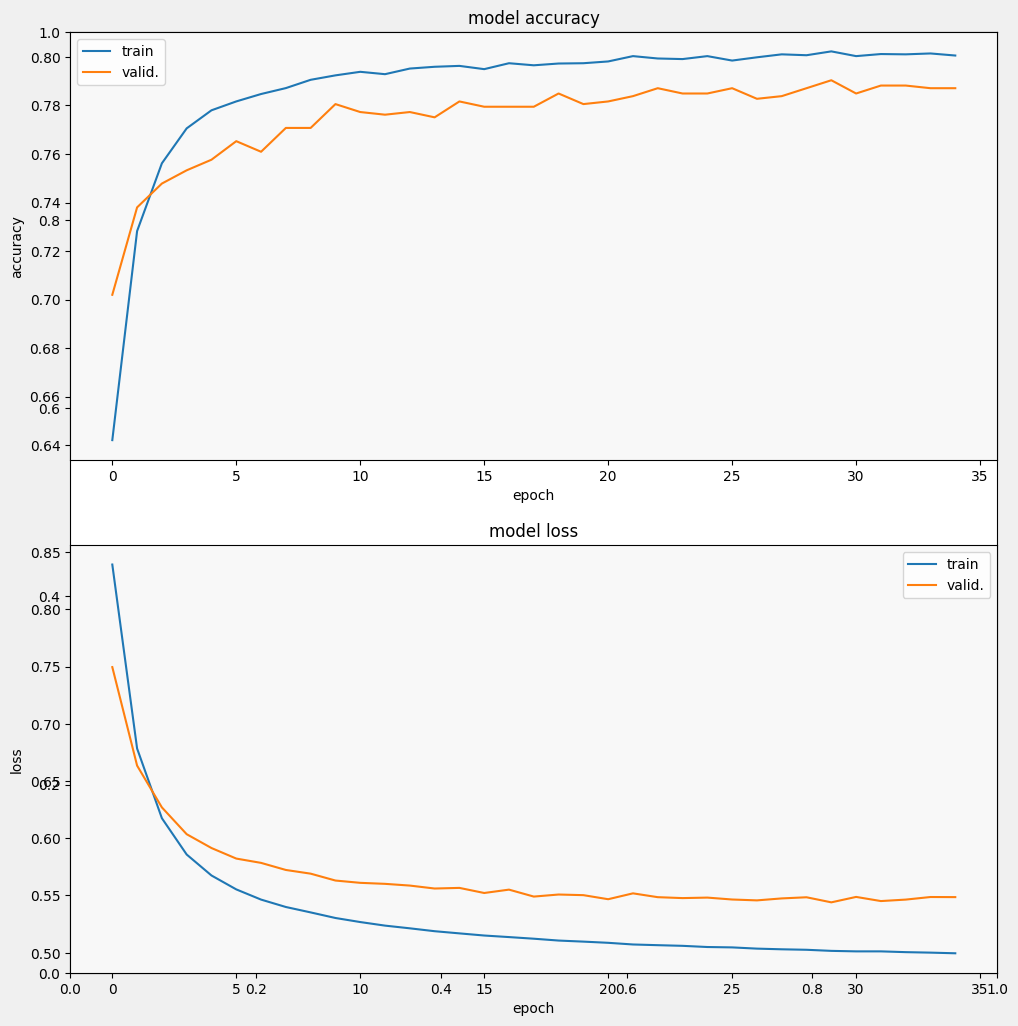

In [9]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print('%s: %.3f' % (name, value))

4/4 - 0s - loss: 0.5406 - accuracy: 0.7805 - 293ms/epoch - 73ms/step


loss: 0.541
accuracy: 0.781


We can see that the loss quickly decreases while especially the accuracy rapidly increases. Let's plot some examples to check how the prediction relates to the true labels:

In [11]:
prediction_dataset = next(iter(test_data.batch(20)))

prediction_texts = [ex.numpy().decode('utf8') for ex in prediction_dataset[0]]
prediction_labels = [label2str(x) for x in prediction_dataset[1]]

predictions = [
    label2str(x) for x in np.argmax(model.predict(prediction_texts), axis=-1)]


pd.DataFrame({
    TEXT_FEATURE_NAME: prediction_texts,
    LABEL_NAME: prediction_labels,
    'prediction': predictions
})

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 122ms/step


string       label  prediction
0   The diffraction grating, LED, and split detect...  background      method
1   Our ideas are based on a previous paper [4] de...  background      method
2   Our finding is consistent with the literature ...      result      result
3   Test scores from each of the cognitive domains...      method      method
4   The optimization algorithm was set to maximize...      method      method
5   To quantify the extent of substitution saturat...      method      method
6   Examples of gesture control are based on the e...      method      method
7   The identification of these features has been ...      method  background
8   Postulated mechanisms for observed effects of ...  background  background
9   The right inferior phrenic artery is the most ...  background  background
10  [8] presented an approach for estimating the t...  background      method
11  Similar structures were observed in M10 cells ...      result      method
12  Cytotoxic effects of cobalt chloride were repo...  background  background
13  However, prolonged incubation of latex enzyme ...  background  background
14  …and travels great distances, resulting in a s...  background  background
15  The images fused using region selection; MSD, ...      method      method
16  These findings were expected, as EMG activity ...      result  background
17  The model has been extended to both 2D and 3D ...      method  background
18  Therefore, many authors claim comprehensive nu...  background      method
19  Similar to Ab40, IAPP-GI populates an aggregat...  background  background

We can see that for this random sample, the model predicts the correct label most of the times, indicating that it can embed scientific sentences pretty well.

# What's next?

Now that you've gotten to know a bit more about the CORD-19 Swivel embeddings from TF-Hub, we encourage you to participate in the CORD-19 Kaggle competition to contribute to gaining scientific insights from COVID-19 related academic texts.

* Participate in the [CORD-19 Kaggle Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)
* Learn more about the [COVID-19 Open Research Dataset (CORD-19)](https://api.semanticscholar.org/CorpusID:216056360)
* See documentation and more about the TF-Hub embeddings at https://tfhub.dev/tensorflow/cord-19/swivel-128d/3
* Explore the CORD-19 embedding space with the [TensorFlow Embedding Projector](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/3/tensorboard/projector_config.json)